v1.0

The objective of this notebook is to check the impact of feature variance on the model and the accuracy score.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [2]:
import time
t_start = time.time()

In [3]:
# Use parameters to enable/disable the fastrun
FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.25
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)

Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
# Required to document module versions
#!pip install watermark
#!pip install catboost
#!pip install xgboost

## Import Modules

In [5]:
# Base libraries
import os
import time

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15,8)})
sns.set(font_scale=0.8)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Define Parameters

In [6]:
seed = 42

cpu_count = os.cpu_count()
#cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
cpu_count = cpu_count

## Helper Functions

In [7]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    conn = http.client.HTTPSConnection("api.pushover.net:443")
    conn.request("POST", "/1/messages.json",
                 urllib.parse.urlencode({
                     "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                     "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                     "message": message,
                 }), {"Content-type": "application/x-www-form-urlencoded"})

    conn.getresponse()


In [8]:
def fast_run_sampling(df, sample_fraction):
    print("Labels before sampling:\n", df['label'].value_counts())

    # Group by label to ensure to get a balanced sample fraction
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed)
    print("Labels after sampling:\n", df['label'].value_counts())

    return df


In [9]:
def calculate_duration(t_start, t_end):
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# Load Data

In [10]:
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"

else:
    ROOT_PATH = "../"
    print("Not a Goolge Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"

df_wiki_train_stats = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT + "train_features_clean_stats.parquet.gzip")
df_wiki_test_stats = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT + "test_features_clean_stats.parquet.gzip")

df_wiki_train_rs = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"train_features_rs.parquet.gzip")
df_wiki_test_rs = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"test_features_rs.parquet.gzip")

df_wiki_train_nltk = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"train_features_nltk.parquet.gzip")
df_wiki_test_nltk = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"test_features_nltk.parquet.gzip")

df_wiki_train_aoa = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"train_features_aoa.parquet.gzip")
df_wiki_test_aoa = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"test_features_aoa.parquet.gzip")

df_wiki_train_crb = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"train_features_crb.parquet.gzip")
df_wiki_test_crb = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"test_features_crb.parquet.gzip")

df_wiki_train_w2v = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"train_features_w2v.parquet.gzip")
df_wiki_test_w2v = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT+"test_features_w2v.parquet.gzip")

df_wiki_train_MNB = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT + 'train_mNB_predict.parquet.gzip')  # data leakage risk
df_wiki_test_MNB = pd.read_parquet(
    ROOT_PATH + PATH_DATA_INT + 'test_mNB_predict.parquet.gzip')    # data leakage risk


Not a Goolge Drive Environment. Loading local files.


In [11]:
# Combine the training dataframes into a single dataframe
df_train = pd.DataFrame()
df_train = pd.concat([df_train,
                      df_wiki_train_stats,
                      df_wiki_train_rs,
                      df_wiki_train_nltk,
                      df_wiki_train_aoa,
                      df_wiki_train_crb,
                      df_wiki_train_w2v,
                      ], axis=1)

# df_train[df_train['stats_language_no'] == 18]['stats_language_code'].head(5)  # checking that 18 is English

columns_list_train = df_train.columns.to_list()
columns_list_train = sorted(list(set(
    columns_list_train) - {"original_text", "cleaned_text", "stats_language_code"}))

print("Features: ", len(columns_list_train))
df_train = df_train[columns_list_train].copy()

if FASTRUN:
    df_train = fast_run_sampling(df_train, sample_fraction)


Features:  152


In [12]:
df_train.shape

(416768, 152)

In [13]:
# Combine the test dataframes into a single dataframe
df_test = pd.DataFrame()
df_test = pd.concat([df_test,
                     df_wiki_test_stats,
                     df_wiki_test_rs,
                     df_wiki_test_nltk,
                     df_wiki_test_aoa,
                     df_wiki_test_crb,
                     df_wiki_test_w2v
                     ], axis=1)

columns_list_test = df_test.columns
columns_list_test = sorted(list(set(
    columns_list_test) - {"original_text", "cleaned_text", "id", "stats_language_code"}))

print("Features: ", len(columns_list_test))
df_test = df_test[columns_list_test].copy()

if FASTRUN:
    df_test = fast_run_sampling(df_test, sample_fraction)


Features:  152


In [14]:
df_test.shape


(119092, 152)

# Feature Selection: Variance

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.dummy import DummyClassifier

# Linear models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Linear/Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier 

# Tree models
from sklearn.tree import DecisionTreeClassifier

# NB models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Neighbors models
#from sklearn.neighbors import KNeighborsClassifier

# Ensemble models
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Scalers
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import VarianceThreshold

In [16]:
# Classifiers for voting classifier
clf1 = RandomForestClassifier(random_state=seed, n_jobs=cpu_count)
clf2 = ExtraTreesClassifier()
clf3 = CatBoostClassifier(logging_level='Silent')
clf4 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('ExTrees', clf1), ('CatBoost', clf2), ('RF', clf3), ('XGB', clf4)], voting='soft')

In [17]:
model_pipeline = {
    'Random Forerst': RandomForestClassifier(random_state=seed, n_jobs=-1),
    'ExTreeClf': ExtraTreesClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(logging_level='Silent'),
    'Logistic Regression': LogisticRegression(random_state=seed, n_jobs=cpu_count, max_iter=3000, solver='lbfgs'),
    #'MLP Classifier': MLPClassifier(random_state=seed, activation='logistic', max_iter=3000),
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Voting CLF': eclf1,
}

In [18]:
X_columns = df_train.columns.to_list()
X_columns = list(set(X_columns) - {"label", "original_text", "cleaned_text"})
print("Features: ",len(X_columns))

X = df_train[X_columns]
y = df_train["label"]
print("Labels: ",len(y))


Features:  151
Labels:  416768


In [19]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.004):
    """
    Return the number of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    scaler = MinMaxScaler((0, 1))
    df_scaled = scaler.fit_transform(df)

    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df_scaled)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return len(feat_select)

In [20]:
fs_variance(df_train, 0.002)

110

In [21]:
%%time
gc.collect()

threshold_list = [0.0, 0.0002, 0.0006, 0.0009, 0.001, 0.01]
features_selected = []
scaler = MinMaxScaler((0, 1))
#scoring_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scoring_list = ['accuracy']
k = 5
kfold = StratifiedKFold(n_splits=k)

result_df = pd.DataFrame({'Model': model_pipeline.keys()})

for threshold_value in threshold_list:
    gc.collect()
    print("Features selected:", fs_variance(df_train,threshold_value))
    features_selected.append(fs_variance(df_train,threshold_value))
    acc_list = []
    # roc_auc_list = []
    # recall_list = []
    # precision_list = []
    # f1_list = []

    for name, model in model_pipeline.items():
        gc.collect()
        print("Cross-validating:", name, "with a threshold of", threshold_value)

        pipeline = Pipeline([('scaling', scaler),('variance', VarianceThreshold(threshold=threshold_value)), ('estimator', model)])
        cv_results = cross_validate(pipeline, X, y, cv=kfold, scoring=['accuracy'], return_estimator=True, n_jobs=-1)  # this works, but pipleline has not feature importnace
        # cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring_list, return_estimator=True, n_jobs=cpu_count, error_score='raise')

        print(np.mean(cv_results['test_accuracy']))
        
        acc_list.append(np.mean(cv_results['test_accuracy']))
        #roc_auc_list.append(np.mean(cv_results['test_roc_auc']))
        #recall_list.append(np.mean(cv_results['test_recall']))
        #precision_list.append(np.mean(cv_results['test_precision']))
        #f1_list.append(np.mean(cv_results['test_f1']))

    threshold_column = str(threshold_value)
    result_df[threshold_column] = acc_list
    display(result_df)


Features selected: 151
Cross-validating: Random Forerst with a threshold of 0.0
0.7429745063165308
Cross-validating: ExTreeClf with a threshold of 0.0
0.7413573030063847
Cross-validating: XGBoost with a threshold of 0.0
0.6966393753758087
Cross-validating: CatBoost with a threshold of 0.0
0.7016253633825935
Cross-validating: Logistic Regression with a threshold of 0.0
0.6656245204448328
Cross-validating: Gaussian NB with a threshold of 0.0
0.6201123881933766
Cross-validating: Multinomial NB with a threshold of 0.0
0.6134708021081605
Cross-validating: Decision Tree with a threshold of 0.0
0.6875983738936778
Cross-validating: Voting CLF with a threshold of 0.0
0.753428766351607


,Model,0.0
0,Random Forerst,0.742975
1,ExTreeClf,0.741357
2,XGBoost,0.696639
3,CatBoost,0.701625
4,Logistic Regression,0.665625
5,Gaussian NB,0.620112
6,Multinomial NB,0.613471
7,Decision Tree,0.687598
8,Voting CLF,0.753429


Features selected: 140
Cross-validating: Random Forerst with a threshold of 0.0002
0.7425690097014255
Cross-validating: ExTreeClf with a threshold of 0.0002
0.7412565289485268
Cross-validating: XGBoost with a threshold of 0.0002
0.6957108008826111
Cross-validating: CatBoost with a threshold of 0.0002
0.7008071629850736
Cross-validating: Logistic Regression with a threshold of 0.0002
0.6654301680107859
Cross-validating: Gaussian NB with a threshold of 0.0002
0.6198916420458318
Cross-validating: Multinomial NB with a threshold of 0.0002
0.6132380580147239
Cross-validating: Decision Tree with a threshold of 0.0002
0.6868113631409443
Cross-validating: Voting CLF with a threshold of 0.0002
0.7529488861681022


,Model,0.0,0.0002
0,Random Forerst,0.742975,0.742569
1,ExTreeClf,0.741357,0.741257
2,XGBoost,0.696639,0.695711
3,CatBoost,0.701625,0.700807
4,Logistic Regression,0.665625,0.665430
5,Gaussian NB,0.620112,0.619892
6,Multinomial NB,0.613471,0.613238
7,Decision Tree,0.687598,0.686811
8,Voting CLF,0.753429,0.752949


Features selected: 133
Cross-validating: Random Forerst with a threshold of 0.0006
0.7431712621280024
Cross-validating: ExTreeClf with a threshold of 0.0006
0.7419499588782558
Cross-validating: XGBoost with a threshold of 0.0006
0.6956724150955786
Cross-validating: CatBoost with a threshold of 0.0006
0.7009919187492704
Cross-validating: Logistic Regression with a threshold of 0.0006
0.6651854264896064
Cross-validating: Gaussian NB with a threshold of 0.0006
0.621220918403075
Cross-validating: Multinomial NB with a threshold of 0.0006
0.6131732740811394
Cross-validating: Decision Tree with a threshold of 0.0006
0.6864394571300205
Cross-validating: Voting CLF with a threshold of 0.0006
0.7538534631574962


,Model,0.0,0.0002,0.0006
0,Random Forerst,0.742975,0.742569,0.743171
1,ExTreeClf,0.741357,0.741257,0.741950
2,XGBoost,0.696639,0.695711,0.695672
3,CatBoost,0.701625,0.700807,0.700992
4,Logistic Regression,0.665625,0.665430,0.665185
5,Gaussian NB,0.620112,0.619892,0.621221
6,Multinomial NB,0.613471,0.613238,0.613173
7,Decision Tree,0.687598,0.686811,0.686439
8,Voting CLF,0.753429,0.752949,0.753853


Features selected: 129
Cross-validating: Random Forerst with a threshold of 0.0009
0.7420051427452343
Cross-validating: ExTreeClf with a threshold of 0.0009
0.7413908941287154
Cross-validating: XGBoost with a threshold of 0.0009
0.6945830779377198
Cross-validating: CatBoost with a threshold of 0.0009
0.6998977843071778
Cross-validating: Logistic Regression with a threshold of 0.0009
0.6651230416155367
Cross-validating: Gaussian NB with a threshold of 0.0009
0.6212497110897296
Cross-validating: Multinomial NB with a threshold of 0.0009
0.6130077143913191
Cross-validating: Decision Tree with a threshold of 0.0009
0.6860963416467963
Cross-validating: Voting CLF with a threshold of 0.0009
0.7525937693134441


,Model,0.0,0.0002,0.0006,0.0009
0,Random Forerst,0.742975,0.742569,0.743171,0.742005
1,ExTreeClf,0.741357,0.741257,0.741950,0.741391
2,XGBoost,0.696639,0.695711,0.695672,0.694583
3,CatBoost,0.701625,0.700807,0.700992,0.699898
4,Logistic Regression,0.665625,0.665430,0.665185,0.665123
5,Gaussian NB,0.620112,0.619892,0.621221,0.621250
6,Multinomial NB,0.613471,0.613238,0.613173,0.613008
7,Decision Tree,0.687598,0.686811,0.686439,0.686096
8,Voting CLF,0.753429,0.752949,0.753853,0.752594


Features selected: 128
Cross-validating: Random Forerst with a threshold of 0.001
0.7423122721630204
Cross-validating: ExTreeClf with a threshold of 0.001
0.7409374056436839
Cross-validating: XGBoost with a threshold of 0.001
0.6945350877085994
Cross-validating: CatBoost with a threshold of 0.001
0.7001857125266677
Cross-validating: Logistic Regression with a threshold of 0.001
0.6650222664062362
Cross-validating: Gaussian NB with a threshold of 0.001
0.6212353125298752
Cross-validating: Multinomial NB with a threshold of 0.001
0.613022110648288
Cross-validating: Decision Tree with a threshold of 0.001
0.6857148328633764
Cross-validating: Voting CLF with a threshold of 0.001
0.7526969431216823


,Model,0.0,0.0002,0.0006,0.0009,0.001
0,Random Forerst,0.742975,0.742569,0.743171,0.742005,0.742312
1,ExTreeClf,0.741357,0.741257,0.741950,0.741391,0.740937
2,XGBoost,0.696639,0.695711,0.695672,0.694583,0.694535
3,CatBoost,0.701625,0.700807,0.700992,0.699898,0.700186
4,Logistic Regression,0.665625,0.665430,0.665185,0.665123,0.665022
5,Gaussian NB,0.620112,0.619892,0.621221,0.621250,0.621235
6,Multinomial NB,0.613471,0.613238,0.613173,0.613008,0.613022
7,Decision Tree,0.687598,0.686811,0.686439,0.686096,0.685715
8,Voting CLF,0.753429,0.752949,0.753853,0.752594,0.752697


Features selected: 65
Cross-validating: Random Forerst with a threshold of 0.01
0.7383268386389055
Cross-validating: ExTreeClf with a threshold of 0.01
0.7365128822807502
Cross-validating: XGBoost with a threshold of 0.01
0.6845271241039302
Cross-validating: CatBoost with a threshold of 0.01
0.6894963142610575
Cross-validating: Logistic Regression with a threshold of 0.01
0.6497475770466832
Cross-validating: Gaussian NB with a threshold of 0.01
0.6158126376299051
Cross-validating: Multinomial NB with a threshold of 0.01
0.6099148692086056
Cross-validating: Decision Tree with a threshold of 0.01
0.6834233889907244
Cross-validating: Voting CLF with a threshold of 0.01
0.7453547311084219


,Model,0.0,0.0002,0.0006,0.0009,0.001,0.01
0,Random Forerst,0.742975,0.742569,0.743171,0.742005,0.742312,0.738327
1,ExTreeClf,0.741357,0.741257,0.741950,0.741391,0.740937,0.736513
2,XGBoost,0.696639,0.695711,0.695672,0.694583,0.694535,0.684527
3,CatBoost,0.701625,0.700807,0.700992,0.699898,0.700186,0.689496
4,Logistic Regression,0.665625,0.665430,0.665185,0.665123,0.665022,0.649748
5,Gaussian NB,0.620112,0.619892,0.621221,0.621250,0.621235,0.615813
6,Multinomial NB,0.613471,0.613238,0.613173,0.613008,0.613022,0.609915
7,Decision Tree,0.687598,0.686811,0.686439,0.686096,0.685715,0.683423
8,Voting CLF,0.753429,0.752949,0.753853,0.752594,0.752697,0.745355


CPU times: user 43.4 s, sys: 2min 42s, total: 3min 25s
Wall time: 1h 35min 48s


In [22]:
# Add new first row with selected features
data_new_row = ['Features Selected'] + features_selected
result_df.loc[-1] = pd.Series(data_new_row, index=result_df.columns)
result_df.index = result_df.index + 1
result_df = result_df.sort_index()
result_df

,Model,0.0,0.0002,0.0006,0.0009,0.001,0.01
0,Features Selected,151.000000,140.000000,133.000000,129.000000,128.000000,65.000000
1,Random Forerst,0.742975,0.742569,0.743171,0.742005,0.742312,0.738327
2,ExTreeClf,0.741357,0.741257,0.741950,0.741391,0.740937,0.736513
3,XGBoost,0.696639,0.695711,0.695672,0.694583,0.694535,0.684527
4,CatBoost,0.701625,0.700807,0.700992,0.699898,0.700186,0.689496
5,Logistic Regression,0.665625,0.665430,0.665185,0.665123,0.665022,0.649748
6,Gaussian NB,0.620112,0.619892,0.621221,0.621250,0.621235,0.615813
7,Multinomial NB,0.613471,0.613238,0.613173,0.613008,0.613022,0.609915
8,Decision Tree,0.687598,0.686811,0.686439,0.686096,0.685715,0.683423
9,Voting CLF,0.753429,0.752949,0.753853,0.752594,0.752697,0.745355


In [23]:
def style_highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: darkgreen' if cell else '' for cell in is_max]

In [24]:
result_df.style\
    .set_properties(**{'text-align': 'center'})\
    .apply(style_highlight_max)\
    .format(
        {
            'Accuracy': '{:,.3f}',
            'Recall': '{:,.3f}',
            'Precision': '{:,.3f}',
            'F1': '{:,.3f}',
            'AUC': '{:,.3f}',
        })\
    .set_caption(f'<br>Cross-validation accuracy scores with kFold={k}<br>Fastrun enabled:{FASTRUN}')\
    .set_table_styles([{
        'selector': 'caption',
        'props': 'caption-side: bottom; font-size:0.9em;'}], overwrite=False)\
    .hide_index()

Model,0.0,0.0002,0.0006,0.0009,0.001,0.01
Features Selected,151.000000,140.000000,133.000000,129.000000,128.000000,65.000000
Random Forerst,0.742975,0.742569,0.743171,0.742005,0.742312,0.738327
ExTreeClf,0.741357,0.741257,0.741950,0.741391,0.740937,0.736513
XGBoost,0.696639,0.695711,0.695672,0.694583,0.694535,0.684527
CatBoost,0.701625,0.700807,0.700992,0.699898,0.700186,0.689496
Logistic Regression,0.665625,0.665430,0.665185,0.665123,0.665022,0.649748
Gaussian NB,0.620112,0.619892,0.621221,0.621250,0.621235,0.615813
Multinomial NB,0.613471,0.613238,0.613173,0.613008,0.613022,0.609915
Decision Tree,0.687598,0.686811,0.686439,0.686096,0.685715,0.683423
Voting CLF,0.753429,0.752949,0.753853,0.752594,0.752697,0.745355


In [25]:
from datetime import date

today = date.today()
print("Today's date:", today)

PATH_DATA_REP = "reports/"
result_df.to_csv(ROOT_PATH+PATH_DATA_REP+f"{today}__feature_selection_variance_table.csv")

Today's date: 2023-02-17


In [55]:
def plot2(df, l1, l2, p1, p2, c="b"):
    feat = []
    feat = df.columns.tolist()
    feat = feat[1:]
    plt.figure(figsize=(16, 18))
    for j in range(0, df.shape[0]):
        value = []
        k = 0
        for i in range(1, len(df.columns.tolist())):
            value.append(df.iloc[j][i])
        plt.subplot(3, 3, j+1)
        ax = sns.pointplot(x=feat, y=value, color=c)
        # set chart title
        ax.set_title(df.iloc[j][0])  # check if this line creates proper chart titles
        #plt.text(p1, p2, df.iloc[j][0])
        plt.xticks(rotation=90)
        ax.set(ylim=(l1, l2))
        k = k+1
    plt.savefig(ROOT_PATH+PATH_DATA_REP+ f"figures/{today}_feature_selection_variance_chart.jpg")

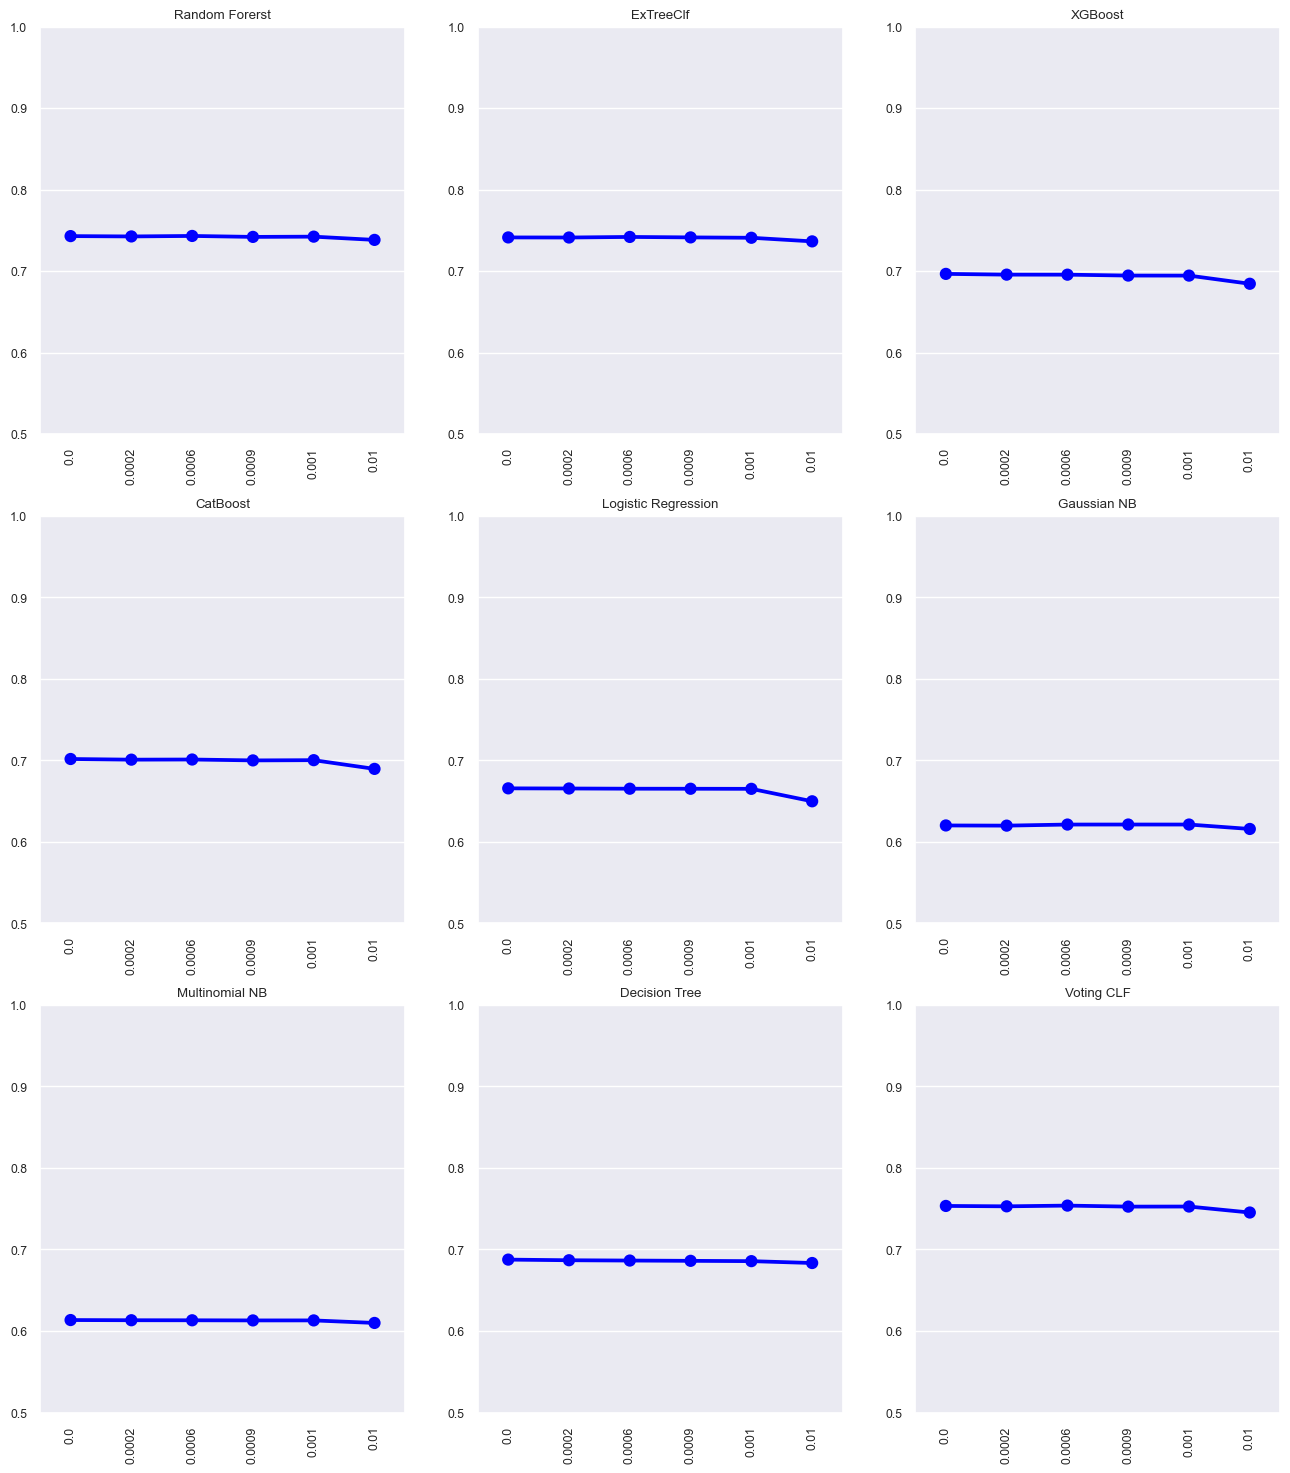

In [58]:
plot_df = result_df.iloc[1:]
plot2(plot_df, 0.5, 1.0, 2.5, 0.91, c="blue")

# Watermark

In [ ]:
%watermark

Last updated: 2023-02-16T01:26:41.216244+01:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.9.0

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [ ]:
%watermark --iversions

pandas    : 1.5.3
numpy     : 1.23.5
seaborn   : 0.12.2
matplotlib: 3.6.3

